In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
sys.path.append(api_path)

In [3]:
import numpy as np
import random
import sklearn

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F


from sir_ais_sampling import (run_experiments_gaussians,
                              run_experiments_2_gaussians,
                              sir_correlated_dynamics,
                              sir_independent_dynamics)

from ebm_sampling import (citerais_mala_dynamics,
                          citerais_ula_dynamics, 
                          i_ais_z_dynamics,
                          i_ais_v_dynamics,
                          i_ais_b_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from torch.distributions import (MultivariateNormal, 
                                 Normal, 
                                 Independent, 
                                 Uniform)

from metrics import Evolution
from general_utils import DotDict, send_file_to_remote

In [4]:
from ebm_sampling import *

In [125]:
loc_target = 4.0
loc_proposal = 0.0

var_proposal = 2.0
var_target = 1.0
scale_proposal = var_proposal ** 0.5
scale_target = var_target ** 0.5
num_points_in_chain = 50
strategy_mean = 'chain'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
batch_size = 50
n_steps = 50

In [126]:
dim = 100

target = init_independent_normal(scale_target, dim, 
                                       device, loc_target)
proposal = init_independent_normal(scale_proposal, dim, 
                                    device, loc_proposal)

In [127]:
vals = []
var = []
# Ns = [2, 5, 10, 20, 50, 75]
# for N in Ns:
rs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1.0]
for r in rs:
    N = 10
    T = 100
    betas = list(np.linspace(1., 0., T)**.5)
    rhos = np.linspace(r, r, T) #[0.9]*T #np.linspace(1, .7, T)

    grad_step = 0.1
    eps_scale = (2*grad_step)**0.5

    method_params = {'n_steps': n_steps, 
                    'N': N, 
                    'grad_step': grad_step, 
                    'eps_scale': eps_scale, 
                    'betas': betas,
                    'rho': 1.0,
                    'rhos': rhos}

    start = proposal.sample([batch_size, len(betas)])

    history, acceptence, traj_hist = citerais_ula_dynamics(start, 
                                                target.log_prob,
                                                proposal,
                                                method_params['n_steps'], 
                                                method_params['grad_step'], 
                                                method_params['eps_scale'],
                                                method_params['N'], 
                                                method_params['betas'],
                                                method_params['rhos'], max_n_rej=1000, pbern=1.0)
    
    last_history = history[-num_points_in_chain:]
    result = torch.stack(last_history, 0)
    ess = (result[1:] != result[:-1]).float().min(-1)[0].mean().item()
    vals.append(ess)

    result_np = result.cpu().numpy()
    result_var = np.var(result_np, axis = 0, ddof=1).mean(axis = 0).mean().item()
    var.append(result_var)


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


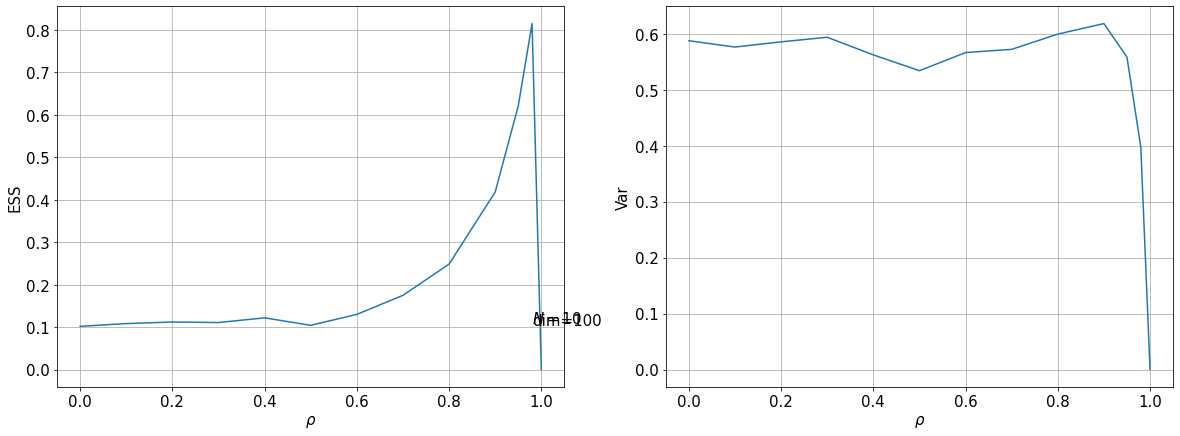

In [128]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
fig, axs = plt.subplots(ncols=2, figsize=(20, 7))
axs[0].plot(rs, vals)
axs[0].set_ylabel(r'ESS')
axs[1].plot(rs, var)
axs[1].set_ylabel(r'Var')
# plt.xlabel(r'$N$')
for ax in axs:
    ax.set_xlabel(r'$\rho$')
    ax.grid()
# # plt.text(50, 0.1, fr'$\rho_0=${rhos[-1]:.2f}, $\rho_T=${rhos[0]:.2f}')
axs[0].text(rs[-2], vals[1], fr'$N=${N}')
axs[0].text(rs[-2], vals[5], fr'dim={dim}')
# # plt.savefig(f'../../ESS_N_dim{dim}.png')
plt.savefig(f'../../ESS_rho_dim{dim}.png')

In [117]:
N = 10
batch_size = 10
T = 100
betas = list(np.linspace(1., 0., T)**.5)
rhos = np.linspace(1.0, 1.0, T) #0.95, 0.95, T) #[0.9]*T #np.linspace(1, .7, T)


grad_step = 0.1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': 1.0,
                 'rhos': rhos}

In [118]:
rhos

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [119]:
start = proposal.sample([batch_size, len(betas)])


In [120]:
history, acceptence, traj_hist = citerais_ula_dynamics(start, 
                                                target.log_prob,
                                                proposal,
                                                method_params['n_steps'], 
                                                method_params['grad_step'], 
                                                method_params['eps_scale'],
                                                method_params['N'], 
                                                method_params['betas'],
                                                method_params['rhos'], max_n_rej=1000, pbern=1.0
                                                )

100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


In [129]:
trs = torch.stack(traj_hist, 0)

In [130]:
trs.shape

torch.Size([51, 5, 100, 100])

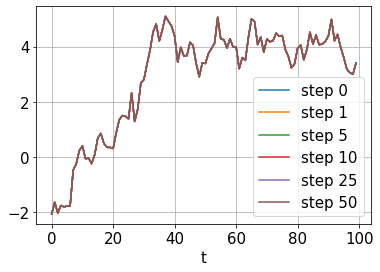

In [135]:
from matplotlib import pyplot as plt

id = 2
dim_id = 59
steps = [0, 1, 5, 10, 25, 50]
for step in steps:
    plt.plot(np.arange(trs.shape[2]), trs[step, id, :, dim_id], label=f'step {step}')

plt.legend()
plt.xlabel('t')
#plt.ylabel(f'{dim_id} coordinate')
plt.grid()
#plt.savefig(f'../../diff_rho{rhos[0]:.1f}.png')

In [81]:
# plt.plot(np.arange(78)+1, acceptence[120].mean(1))
# plt.savefig('../../accept_rate.png')

In [82]:
#acceptence[-1].mean(0)

In [19]:
start_res = torch.stack(history, 0)
print('fraction of acceptions of initial traj', (start_res[1:] != start_res[:-1]).float().min(-1)[0][0].mean().item())

fraction of acceptions of initial traj 0.8399999737739563


In [20]:
last_history = history[-num_points_in_chain:]
result = torch.stack(last_history, 0)#[..., -1, :]

In [21]:
print('fraction of acceptions', (result[1:] != result[:-1]).float().min(-1)[0].mean().item())
# print((result[1:] != result[:-1]).float()[..., 0][0].mean(0)[0].item())

fraction of acceptions 0.32326531410217285


In [86]:
result_np = result.cpu().numpy()

In [87]:
# over chain
result_var = np.var(result_np, axis = 0, ddof=1).mean(axis = 0)#.mean()
result_mean = np.mean(result_np, axis = 0).mean(axis = 0)#.mean()

# # over batch
# result_var = np.var(result_np, axis = 1, ddof=1).mean(axis = 0).mean()
# result_mean = np.mean(result_np, axis = 1).mean(axis = 0).mean()

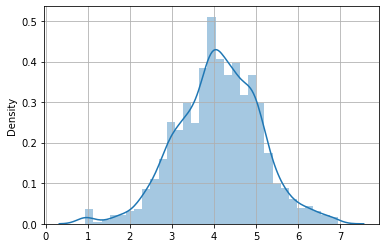

In [88]:
import seaborn as sns

dim_id = 14
sns.distplot(result_np[..., dim_id])
plt.grid()

#plt.savefig(f'../../hist_rho{rhos[0]:.1f}_dim{dim_id}.png')

In [89]:
result_mean, result_var, result_mean.mean(), result_var.mean()

(array([4.1041503, 4.0106115, 4.0268965, 3.9774518, 3.9442072, 4.0207777,
        4.077754 , 4.097292 , 4.0430913, 4.0043793, 3.9203243, 4.0942116,
        4.080554 , 3.9572296, 4.1087446, 3.9733407, 4.0407124, 4.045279 ,
        3.9350204, 3.98436  , 3.9696198, 4.011236 , 4.0200953, 4.011995 ,
        3.8965695, 4.045061 , 3.957177 , 4.1035385, 4.1005745, 4.0756063,
        3.8919713, 3.9120219, 4.0219173, 3.9967082, 4.044264 , 4.031146 ,
        4.0347347, 3.9727435, 3.9360678, 3.9782984, 3.8604174, 3.9630854,
        3.9236026, 3.954218 , 3.9742265, 3.889849 , 3.9818585, 4.0251217,
        4.006232 , 3.9864697, 3.9422936, 3.9214437, 4.0832486, 4.114444 ,
        4.007909 , 4.006131 , 3.9109986, 3.9815872, 4.0701666, 3.9988601,
        4.06373  , 3.9358618, 3.9294202, 4.16195  , 4.066744 , 4.0116224,
        4.024476 , 3.9776723, 3.9854681, 3.9187078, 4.0073953, 4.079898 ,
        3.9111187, 3.923876 , 4.002139 , 4.0452685, 3.9601514, 3.904273 ,
        4.0104423, 4.012394 , 3.932491

In [147]:
dim_arr = [100]

N = 2

T = 100
betas = np.linspace(1., 0., T)**.5
rhos = [0.]*T

grad_step = 0.1
eps_scale = (2*grad_step)**0.5

n_steps = 100

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rhos': rhos,
                 'rho': 1.0}
random_seed = 46
method = 'citerais_ula' 
mode_init = 'proposal'
print_results = True
strategy_mean = 'chain'

results_citerais_ula = run_experiments_gaussians(dim_arr,  
                                          scale_proposal, 
                                          scale_target, 
                                          loc_target,
                                          num_points_in_chain, 
                                          strategy_mean,
                                          device,
                                          batch_size,
                                          method_params,
                                          random_seed = random_seed,
                                          loc_proposal = loc_proposal,
                                          mode_init = mode_init,
                                          method = method,
                                          print_results = print_results) 

  0%|          | 0/100 [00:00<?, ?it/s]------------------
mode = proposal
dim = 100
100%|██████████| 100/100 [00:22<00:00,  4.53it/s]
mean estimation of acceptence rate = 1.0
mean estimation of variance = 0.9835978150367737
mean estimation of mean = 3.996108055114746
mean estimation of ess = 0.26056565656565656
------


In [90]:
dim = 100

loc_1_target = 3
loc_2_target = -3

target_args = DotDict()
target_args.device = device
target_args.num_gauss = 2

coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [loc_1_target*torch.ones(dim, dtype = torch.float64).to(device),
    loc_2_target*torch.ones(dim, dtype = torch.float64).to(device)]
locs_numpy = torch.stack(locs, axis = 0).cpu().numpy()
target_args.locs = locs
target_args.covs = [(scale_target**2)*torch.eye(dim, 
                                                dtype = torch.float64).to(device)]*target_args.num_gauss
target_args.dim = dim
target = Gaussian_mixture(target_args)
proposal = init_independent_normal(scale_proposal, dim, device, loc_proposal)

In [41]:
N = 2

T = 100
betas = list(np.linspace(1., 0., T)**.5)
rhos = [0.9] * T #np.linspace(1, .0, T)#**.5

#betas = list(np.linspace(1., 0.85, 50)) + list(np.linspace(0.85, 0., 30))

grad_step = 0.1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': 1.0,
                 'rhos': rhos}

In [42]:
batch_size = 50

In [43]:
start = proposal.sample([batch_size, len(betas)])

In [44]:
history, acceptence, traj_hist = citerais_ula_dynamics(start, 
                                                target.log_prob,
                                                proposal,
                                                method_params['n_steps'], 
                                                method_params['grad_step'], 
                                                method_params['eps_scale'],
                                                method_params['N'], 
                                                method_params['betas'],
                                                method_params['rhos']
                                                )

100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


In [45]:
history[-1].shape

torch.Size([50, 25])

In [46]:
last_history = history[-num_points_in_chain:]
result = torch.stack(last_history, 0)
print('fraction of acceptions', (result[1:] != result[:-1]).float().min(-1)[0].mean().item())

result_np = result.cpu().numpy()
# over chain
result_var = np.var(result_np, axis = 0, ddof=1).mean(axis = 0)#.mean()
result_mean = np.mean(result_np, axis = 0).mean(axis = 0)#.mean()


fraction of acceptions 0.3306122422218323


In [47]:
result_np.shape

(50, 50, 25)

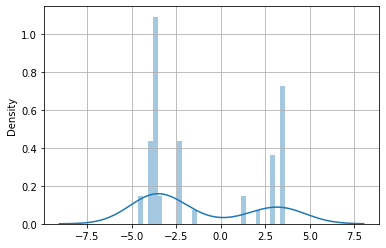

In [52]:
import seaborn as sns

dim_id = 4
chain_id = 41
sns.distplot(result_np[:, chain_id, dim_id], bins=30)
plt.grid()
#plt.savefig('../../hist.png')

In [54]:
from scipy.stats import chi2

test_dist = (chi2.ppf(.95, dim) * (scale_target**2))**.5

(np.linalg.norm(result_np - np.array([-3.]*dim)[None, None, :], axis=-1) < test_dist).sum()

1164

In [55]:
result_np.shape

(50, 50, 25)

In [56]:
trs = torch.stack(traj_hist, 0)

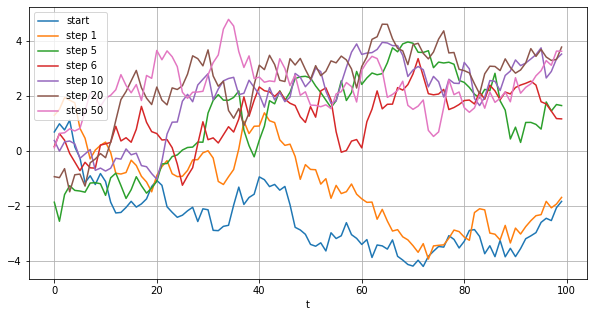

In [57]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
id = 1
dim_id = 6
plt.plot(np.arange(trs.shape[2]), trs[0, id, :, dim_id], label='start')
plt.plot(np.arange(trs.shape[2]), trs[1, id, :, dim_id], label='step 1')
plt.plot(np.arange(trs.shape[2]), trs[5, id, :, dim_id], label='step 5')
plt.plot(np.arange(trs.shape[2]), trs[6, id, :, dim_id], label='step 6')
plt.plot(np.arange(trs.shape[2]), trs[10, id, :, dim_id], label='step 10')
plt.plot(np.arange(trs.shape[2]), trs[20, id, :, dim_id], label='step 20')
plt.plot(np.arange(trs.shape[2]), trs[50, id, :, dim_id], label='step 50')
plt.legend()
plt.xlabel('t')
#plt.ylabel(f'{dim_id} coordinate')
plt.grid()
#plt.savefig('../../diff.png')

In [166]:
trs.shape

torch.Size([101, 5, 100, 100])

In [107]:
batch_size

50

In [108]:
dim_arr = [100]

batch_size = 1 #00

mode_init = 'proposal'
method = 'citerais_ula'
print_results = True
strategy_mean = 'chain'

random_seed = 506

N = 10

T = 70 #100
betas = list(np.linspace(1., 0., T)**.5)
rhos = [.95]*T #np.linspace(.4, .0, T)#**.5#[::-1]#**3#**.5
#rhos[-1] = 1


grad_step = 0.1
eps_scale = (2*grad_step)**0.5

method_params = {'n_steps': n_steps, 
                 'N': N, 
                 'grad_step': grad_step, 
                 'eps_scale': eps_scale, 
                 'betas': betas,
                 'rho': 1.0,
                 'rhos': rhos}

result = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

  0%|          | 0/100 [00:00<?, ?it/s]------------------
mode = proposal
dim = 100
100%|██████████| 100/100 [00:20<00:00,  4.78it/s]
mean estimation of acceptence rate = 1.0
mean estimation of target variance = 0.7464944937751739
mean estimation of 1 mode mean  = 2.9515926837921143
mean estimation of 2 mode mean  = -2.997804880142212
mean estimation of JSD  = 0.000801723450422287
mean estimation of HQR  = 1.0
mean estimation of ESS = 0.40816326530612246
------


In [59]:
method_params['rhos'] = [0.7]*T

In [170]:
result = run_experiments_2_gaussians(dim_arr,
                                              scale_proposal,
                                              scale_target,
                                              loc_1_target,
                                              loc_2_target,
                                              num_points_in_chain,
                                              strategy_mean,
                                              device,
                                              batch_size,
                                              method_params,
                                              random_seed=random_seed,
                                              loc_proposal=loc_proposal,
                                              mode_init=mode_init,
                                              method=method,
                                              print_results=print_results)

  0%|          | 0/100 [00:00<?, ?it/s]------------------
mode = proposal
dim = 100
100%|██████████| 100/100 [00:20<00:00,  4.97it/s]
mean estimation of acceptence rate = 1.0
mean estimation of target variance = 0.766730602427649
mean estimation of 1 mode mean  = 2.986027240753174
mean estimation of 2 mode mean  = -2.9890706539154053
mean estimation of JSD  = 0.019418458612635164
mean estimation of HQR  = 0.9878000062704086
mean estimation of ESS = 0.28202020202020206
------


In [109]:
dim = 100
batch_size = 150
n_steps = 100

from scipy.stats import chi2

test_dist = (chi2.ppf(.95, dim) * (scale_target**2))**.5

vals = []
var = []
nss = []
# Ns = [2, 5, 10, 20, 50, 75]
# for N in Ns:

rs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
for r in rs:
    N = 10
    T = 70
    betas = list(np.linspace(1., 0., T)**.5)
    rhos = np.linspace(r, r, T) #[0.9]*T #np.linspace(1, .7, T)

    grad_step = 0.1
    eps_scale = (2*grad_step)**0.5

    method_params = {'n_steps': n_steps, 
                    'N': N, 
                    'grad_step': grad_step, 
                    'eps_scale': eps_scale, 
                    'betas': betas,
                    'rho': 1.0,
                    'rhos': rhos}

    start = proposal.sample([batch_size, len(betas)])

    history, acceptence, traj_hist = citerais_ula_dynamics(start, 
                                                target.log_prob,
                                                proposal,
                                                method_params['n_steps'], 
                                                method_params['grad_step'], 
                                                method_params['eps_scale'],
                                                method_params['N'], 
                                                method_params['betas'],
                                                method_params['rhos'], max_n_rej=1000, pbern=0.8)
    
    last_history = history[-num_points_in_chain:]
    result = torch.stack(last_history, 0)
    ess = (result[1:] != result[:-1]).float().min(-1)[0].mean().item()
    vals.append(ess)

    evolution = Evolution(None, locs=torch.stack(locs, 0).cpu(), sigma=scale_target)

    ns = np.zeros((batch_size, 2))  
    for i in range(batch_size):
        X_gen = result[:, i, :] #torch_last_history[:, i, :]
        assignment = Evolution.make_assignment(X_gen, evolution.locs, evolution.sigma)
        mode_var = Evolution.compute_mode_std(X_gen, assignment).item()**2

        X_gen = X_gen.cpu().numpy()
        n1 = (np.linalg.norm(X_gen - np.array([-3.]*dim)[None, None, :], axis=-1) < test_dist).mean() / 0.5
        n2 = (np.linalg.norm(X_gen - np.array([3.]*dim)[None, None, :], axis=-1) < test_dist).mean() / 0.5
        ns[i] = np.array([n1, n2])

    nss.append(ns)

    mode_var = np.array(mode_var)#.mean()
    var.append(mode_var)


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


In [110]:
(np.array(nss).min(-1) > 0).mean(1)#[-1] / 2

array([0.4       , 0.48      , 0.41333333, 0.34      , 0.22666667,
       0.14      , 0.1       , 0.04      , 0.07333333, 0.06666667,
       0.56      , 0.86      ])

In [111]:
var = np.array(var)

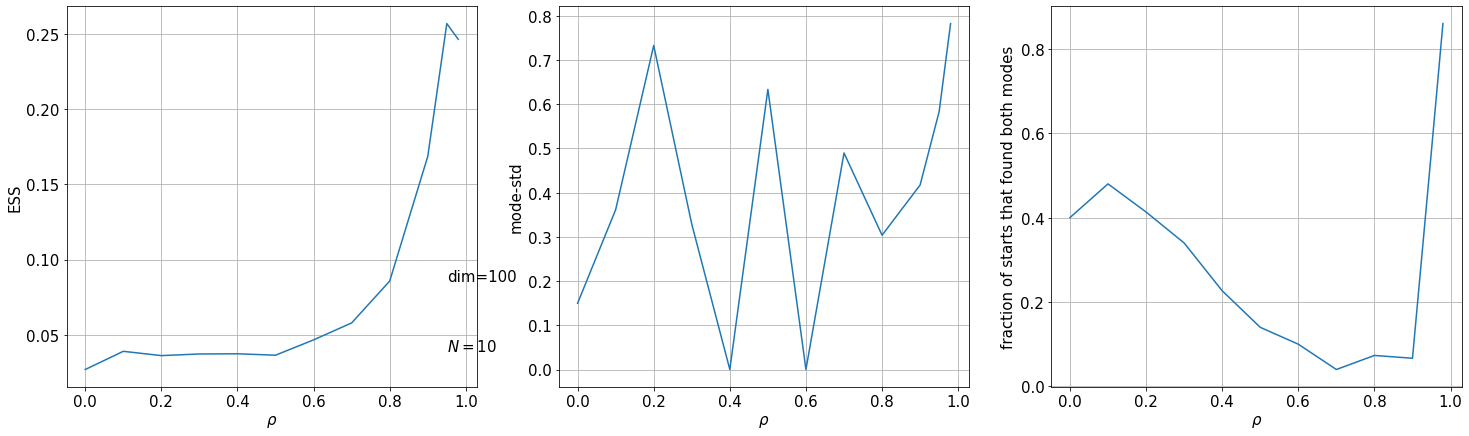

In [113]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
fig, axs = plt.subplots(ncols=3, figsize=(25, 7))
axs[0].plot(rs, vals)
axs[0].set_ylabel(r'ESS')
axs[1].plot(rs, var)
# axs[1].plot(rs, var[:, 0])
axs[1].set_ylabel(r'mode-std')

axs[2].plot(rs, (np.array(nss).min(-1) > 0).mean(1))
axs[2].set_ylabel('fraction of starts that found both modes')
# axs[2].plot(rs, var[:, 1])
# axs[2].set_ylabel(r'Var2')
# plt.xlabel(r'$N$')
for ax in axs:
    ax.set_xlabel(r'$\rho$')
    ax.grid()
# # plt.text(50, 0.1, fr'$\rho_0=${rhos[-1]:.2f}, $\rho_T=${rhos[0]:.2f}')
axs[0].text(rs[-2], vals[1], fr'$N=${N}')
axs[0].text(rs[-2], vals[8], fr'dim={dim}')
# # plt.savefig(f'../../ESS_N_dim{dim}.png')
plt.savefig(f'../../ESS_rho_dim{dim}_bern_2.png')